In [1]:
import torch 
import torch.autograd.variable as Variable
import torchvision
from torchvision import transforms, datasets
import os
import cv2
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_data = np.load("pokemon_training.npy", allow_pickle= True)

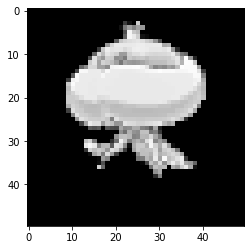

(50, 50)

In [3]:
img = train_data[9]
plt.imshow(img, cmap = "gray")
plt.show()
train_data[0].shape

In [4]:

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*3*3)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 3, 3)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)

In [5]:
# Here we will overfit a cnn model that resembles the discrimator in our LeakyGAN

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        
        
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        
        
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        
        
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        
        
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*3*3, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.main(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*3*3)
        x = self.out(x)
        return x
    

    
    def feature_extraction(self,x):        
        x = self.main(x)
        return x.view(-1,1024*3*3)

In [6]:
def noise(size):
    
    n = Variable(torch.randn(size,100))
    return n.cuda()

In [7]:
def init_weights(m):
    
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find("BatchNorm")!= -1:
        m.weight.data.normal_(0.00,0.02)

In [8]:
G = Generator()

In [9]:
G.apply(init_weights)
D = Discriminator()
D.apply(init_weights)

G.cuda()
D.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (out): Sequential(
    (0): Linear(in_features=9216, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = D(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = D(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake


In [11]:
# Optimizers
d_optimizer = optim.Adam(D.parameters(), lr=0.009, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0003, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 400

In [12]:
def real_data_target(size):

    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [13]:
def train_generator(optimizer, fake_data):
    
    optimizer.zero_grad()
    prediction = D(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    optimizer.step()
    return error

In [14]:
num_test_samples = 16
test_noise = noise(num_test_samples)
from utils import Logger


C:\Users\Sanket\Miniconda3\lib\site-packages\torch\autograd\__init__.py:179: UserWarning: torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead
  warnings.warn("torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead")
C:\Users\Sanket\Miniconda3\lib\site-packages\torch\autograd\__init__.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(*args, **kwargs)


In [15]:
train_data.shape
batch_size = 60

X = torch.Tensor([i for i in train_data]).view(-1,1,50,50)
#X = X/255


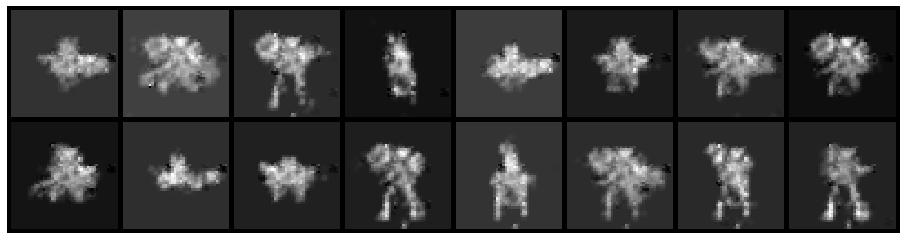

Epoch: [399/400], Batch Num: [10/12.0]
Discriminator Loss: 0.0024, Generator Loss: 17.6298
D(x): 0.9999, D(G(z)): 0.0022


In [16]:
from IPython import display

logger = Logger(model_name='DCGAN', data_name='Cats')

for epoch in range(num_epochs):
    if(epoch==399):
        torch.save(G,"Models/Regular/ep400.pth")
    n_batch = 0
    for i in range(0,720,batch_size):
        
        
        #  Discriminator
        real_data = Variable(X[i:i+batch_size])
        n_batch+=1
        #real_data = real_data[:,0,:,:].unsqueeze(1)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = G(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # Generator
        # Generate fake data
        fake_data = G(noise(batch_size))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, 720/batch_size)
        
        # Display Progress
        if (n_batch) % 5 == 0:
            display.clear_output(True)
            # Display Images
            test_images = G(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch,n_batch, 720/batch_size);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, 720/batch_size,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(G, D, epoch)